# Import libraries

In [1]:
import numpy as np
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import random
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
pd.set_option('display.max_colwidth', None)

2024-05-18 19:35:19.637104: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 19:35:20.090319: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Create corpus and Preprocessing

Let's remove all punctutation marks and make everything lowercase.

In [2]:
# Define the remove_non_english function
def remove_non_english(text):
    # Regular expression to remove non-English alphabet characters
    english_only = re.sub(r'[^a-zA-Z\s.,;?!\'-]', '', text)
    return english_only

# Define the create_corpus function
def create_corpus(text):
    # Tokenize text into sentences
    sentences = text.split('\n')
    # Remove empty strings
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    # Join sentences into a corpus
    corpus = '\n'.join(sentences)  # Keep newline characters
    return corpus.replace(',', '<COMA>').replace('\n', '<END>')

# Read the CSV file
csv_path = "../data_raw/our_dataset.csv"
df = pd.read_csv(csv_path)

# Apply remove_non_english function to poem column
df['poem'] = df['poem'].apply(remove_non_english)

# Apply create_corpus function to poem column
df['poem'] = df['poem'].apply(create_corpus)

# Remove \xa0
df['poem'] = df['poem'].str.replace('\xa0', '')

# Apply lowercase to the poem column
df['poem'] = df['poem'].str.lower()

# Print the DataFrame
df


,Unnamed: 0,poem,topic
0,0,"sunday we lay hands\non a girl of ten hand on hand on\ncornsilk hair. we sing\nthe secret language sung\nthe day the tin roof of the tower beat\non gods floorboard\nhe got cramp in heaven.\nlike our crying and our\nfornicating so close to his bed\nwas so many shrill mice in a pretty\npine floor. to heal\nthe girl with the crippled up leg\ngod sends back the song\nhe took and down it comes\ncontrary in one mouth as fire\ngentle on our bodies as rain.\nsoft rain swells the cumberland\nand all her fields in april nuzzles\nbuttercups the mules wont touch\nthe crowpoison the wake-robin\nthe bluets of the field.\nevery song got a beat beneath.\nstart with the whippoorwill\nearly meadow colors creep\ninto the sky. my sons made this\ntobacco sled i prime with the jenny\ntoss the last of the sandlugs for the rest\nto thrive. so hot the wasps hang on the honeysuckle\ntoo spent to buzz a sermon.\ni know my song remembers\nwhat my fathers told their strings.\ndriskill, kentuckydriskill, kentucky",religion
1,1,"o transientvoyager of heaven!\no silent sign of winter skies!\nwhat adverse wind thy sail has driven\nto dungeons where a prisoner lies?\nmethinks the hands that shut the sun\nso sternly from this morning's brow\nmight still their rebel task have done\nand checked a thing so frail as thou.\nthey would have done it had they known\nthe talisman that dwelt in thee,\nfor all the suns that ever shone\nhave never been so kind to me!\nfor many a week, and many a day\nmy heart was weighed with sinking gloom\nwhen morning rose in mourning grey\nand faintly lit my prison room\nbut angel like, when i awoke,\nthy silvery form, so soft and fair\nshining through darkness, sweetly spoke\nof cloudy skies and mountains bare;\nthe dearest to a mountaineer\nwho, all life long has loved the snow\nthat crowned his native summits drear,\nbetter, than greenest plains below.\nand voiceless, soulless, messenger\nthy presence waked a thrilling tone\nthat comforts me while thou art here\nand will sustain when thou art gone",religion
2,2,"a cento for sarah hegazy\na cento for sarah hegazy\na cento for sarah hegazyin the hiding\nhour of autophagy\nghosts hang out all day and talk to us.\nan archival haunting demanding tribute\nhalf a lime for breakfast every day.\nhuman voices keening in pain\ntheir bodies, consumed by fire\nlight up the dark\n.\nthey will blame the early morning hours\nunder the seal of secrecy\nwhere there was no sunrise\nthough\nmoon tells me god is love unconditional. i\nten thousand years old and no wind\nmilk souring on my tongue\nwhisper until we sleep\ndo you see the map home?\nthis world will have you running to stone for embrace\ngravestone gentler than human.\nthe wretched left a monument of comments that day\nin the place of thunder,\ni have faith in a world of signs and wonder.\nthis time it will be different\narab spring forcing its way\nold life re-members\nlightening would manifest from the stale air.\nyou are prepared for all of it\nparaded processions wedding ecstatic\nwhen the fists rush towards your gut\nthey will find instead smoke.\nour desire up to our throats,\nincreased blood flow ripping heart open from within\ndead now after decimating perfectly healthy skin\nwe will become history contested.\na light in the earth of her chest.\ngrief is a country without borders\neulogy to be read from right to left\nbabas tongue buried in sand\ni dream in arabic of salt drink gallons\nbut the ocean stays the ocean and once again i wake\nam a wake in english.\nim thirsty is whats killing me most.\ndont die this way.\nwake up drink water one foot and then the next walk meet the sun\na face that is so itself\nto look upon it on that summer day was like drinking\nprism refracting rainbow\nrupture rapture\nwho washed her, who folded her into eternity, who\nthis is the only river i want to write about.\ni am the entire galaxy in a drop.\ndont you know i am everything?\nan absconded city of bees.\na novel adject

In [3]:
# Create an empty list to store lines of text
corpus = []

# Initialize a counter for the number of lines added to the corpus
line_count = 0

# Iterate over each poem in the DataFrame
for poem in df['poem']:
    # Split the poem into lines
    lines = poem.split('\n')
    # Iterate over each line in the poem
    for line in lines:
        # Append the line to the corpus
        corpus.append(line)
        # Increment the line count
        line_count += 1
        # Check if the corpus has reached the maximum size of 10,000 lines
        if line_count >= 10000:
            break
    # Check if the corpus has reached the maximum size of 10,000 lines
    if line_count >= 10000:
        break
    
corpus[:10]


['sunday we lay hands',
 'on a girl of ten hand on hand on',
 'cornsilk hair. we sing',
 'the secret language sung',
 'the day the tin roof of the tower beat',
 'on gods floorboard',
 'he got cramp in heaven.',
 'like our crying and our',
 'fornicating so close to his bed',
 'was so many shrill mice in a pretty']

In [4]:
len(corpus)

10000

# Tokenization

Models can't understand words, so we need to convert our words into numbers. This is what Tokenization does.

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [6]:
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 14780


# Generate n-grams

N-grams are the way we convert a poetry generation problem into a supervised learning problem.

Here is how it works.

**1. Tokenize sentence**

```
sentence = poetry generation is so much fun

tokens = [ 42, 124, 9, 12, 97, 512]
```

**2. Generate n-grams**

```
tokens = [ 42, 124, 9, 12, 97, 512]

N-grams:

    [ 42, 124 ]                   # first two words
    [ 42, 124, 9 ]                # first three words
    [ 42, 124, 9, 12 ]            # first four words
    [ 42, 124, 9, 12, 97 ]        # first five words
    [ 42, 124, 9, 12, 97, 512 ]   # first six words
```

**3. Pad n-grams**

Padding is how we make all the n-grams the same length.

```
Padded N-grams:

    [ 0, 0, 0, 0, 42, 124 ]
    [ 0, 0, 0, 42, 124, 9 ]
    [ 0, 0, 42, 124, 9, 12 ]
    [ 0, 42, 124, 9, 12, 97 ]
    [ 42, 124, 9, 12, 97, 512 ]
```

**4. Split n-grams into X and y**

Our aim is to create a model which can predict the next most probable word, given an input sequence.

Therefore we can split our n-grams in the following way: The last token is our label (Y) and the preceding tokens are the features (X).

```
Padded N-grams, split into X and y:

             X                  Y

    [ 0, 0, 0, 0, 42]        [ 124 ]
    [ 0, 0, 0, 42, 124 ]     [ 9 ]
    [ 0, 0, 42, 124, 9 ]     [ 12 ]
    [ 0, 42, 124, 9, 12 ]    [ 97 ]
    [ 42, 124, 9, 12, 97 ]   [ 512 ]

```

## Tokenize and Generate n-grams

In [7]:
n_grams = []
max_sequence_len = 0

for sentence in corpus:
    # convert sentence to tokens
    tokens = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(2, len(tokens)+1):
        # extract n-gram
        n_gram = tokens[:i]
        # save n-gram
        n_grams.append(n_gram)
        # calculate maximum sequence length
        if len(n_gram) > max_sequence_len:
            max_sequence_len = len(n_gram)
        
print(f"Number of n-grams: {len(n_grams)}")
print(f"Maximum n-gram length: {max_sequence_len}")

Number of n-grams: 67329
Maximum n-gram length: 1646


In [8]:
for n_gram in n_grams[:10]:
    print(n_gram)

[507, 27]
[507, 27, 549]
[507, 27, 549, 216]
[16, 4]
[16, 4, 301]
[16, 4, 301, 3]
[16, 4, 301, 3, 762]
[16, 4, 301, 3, 762, 132]
[16, 4, 301, 3, 762, 132, 16]
[16, 4, 301, 3, 762, 132, 16, 132]


## Pad n-grams

In [9]:
padded_n_grams = np.array(pad_sequences(n_grams, maxlen=100, padding="pre", truncating="pre"))

padded_n_grams.shape

(67329, 100)

In [10]:
for seq in padded_n_grams[:3]:
    print(seq)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0 507  27]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0 507  27 549]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0

## Split n-grams into X and y

In [11]:
X = padded_n_grams[:, :-1]
y = padded_n_grams[:, -1]

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (67329, 99)
y: (67329,)


In [12]:
# one hot encode y

y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

print(f"y: {y.shape}")

y: (67329, 14780)


# Modelling

Now let's create a model which can predict the next most probable word, given an input sequence.

In [13]:
model = tf.keras.Sequential([
    Embedding(vocab_size, 300),
    LSTM(150),
    Dense(vocab_size, activation="softmax"),
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

2024-05-18 19:35:21.133571: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-18 19:35:21.157866: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.fit(
    X, 
    y, 
    epochs=125,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=20)
    ],
)

Epoch 1/125


2024-05-18 19:35:23.007999: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3980490480 exceeds 10% of free system memory.


527/527 ━━━━━━━━━━━━━━━━━━━━ 60s 112ms/step - accuracy: 0.0516 - loss: 8.0081
Epoch 2/125
527/527 ━━━━━━━━━━━━━━━━━━━━ 61s 115ms/step - accuracy: 0.0672 - loss: 7.2259
Epoch 3/125
527/527 ━━━━━━━━━━━━━━━━━━━━ 62s 118ms/step - accuracy: 0.0816 - loss: 6.8984
Epoch 4/125
527/527 ━━━━━━━━━━━━━━━━━━━━ 61s 115ms/step - accuracy: 0.0915 - loss: 6.6694
Epoch 5/125
527/527 ━━━━━━━━━━━━━━━━━━━━ 59s 112ms/step - accuracy: 0.0984 - loss: 6.4442
Epoch 6/125
527/527 ━━━━━━━━━━━━━━━━━━━━ 62s 117ms/step - accuracy: 0.1057 - loss: 6.2378
Epoch 7/125
527/527 ━━━━━━━━━━━━━━━━━━━━ 66s 125ms/step - accuracy: 0.1176 - loss: 5.9859
Epoch 8/125
527/527 ━━━━━━━━━━━━━━━━━━━━ 63s 119ms/step - accuracy: 0.1272 - loss: 5.7747
Epoch 9/125
527/527 ━━━━━━━━━━━━━━━━━━━━ 61s 115ms/step - accuracy: 0.1385 - loss: 5.5502
Epoch 10/125
527/527 ━━━━━━━━━━━━━━━━━━━━ 60s 114ms/step - accuracy: 0.1495 - loss: 5.3154
Epoch 11/125
527/527 ━━━━━━━━━━━━━━━━━━━━ 60s 114ms/step - accuracy: 0.1620 - loss: 5.0995
Epoch 12/125
527/527

# Plot learning curves

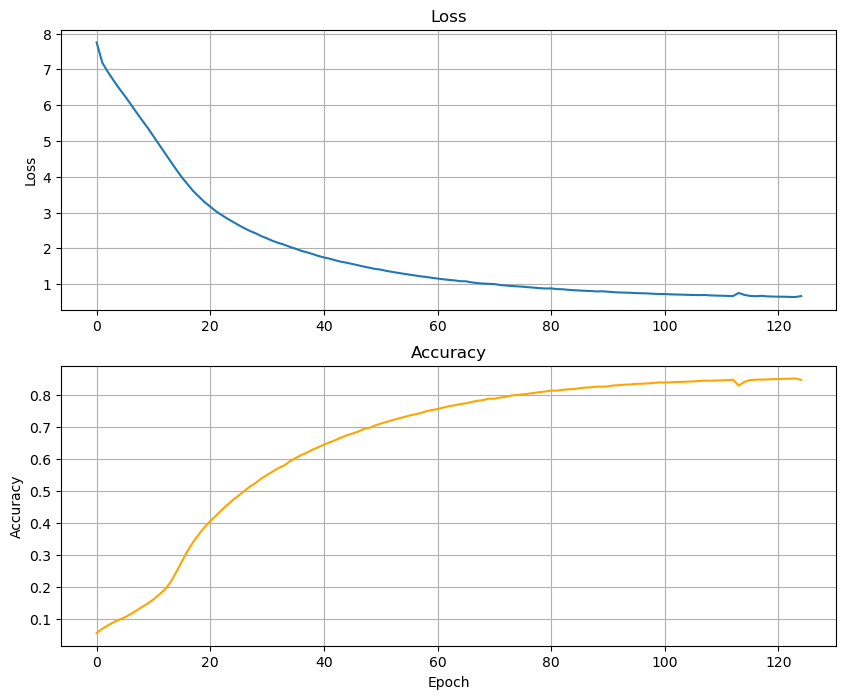

In [15]:
hist = model.history.history

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(hist["loss"])
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(hist["accuracy"], color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.show()

# Poetry generation

In [16]:
def generate(seed_text, next_words):
    generated_text = ""
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=99, padding="pre")
        predicted = np.argmax(model.predict(token_list, verbose=0))
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        if output_word == '<END>':  # Replace <End> with '.'
            generated_text += '.'
        elif output_word == '<COMMA>':  # Replace <Comma> with ','
            generated_text += ','
        else:
            generated_text += output_word + " "
        seed_text += " " + output_word
    print(generated_text)

In [17]:
generate("Long live the king", 200)

Long live the king so talking too much can warm here and synne destroye. to be dubbed aboute his eel ws. i shal apeire yow his scent ring. . . he did he he did you find the priest in the yard laugh into the air what he had been saying please. the boys pause to consider so he continues we sat into the night talking about no place of the bright a grazing in its star apple bill singed you did the sign of the apocalyptic populist ignite and burn out the grooves from your fingerprints how loud did you holler shocked did your wallet keep falling into the floor and never stop did the floor wobble like a trampoline did a menacing voice laugh and say on gods intercom here is your shadow catch did you fall through the hole in the carpet did you land in one of the old sewers and in the distance see someone sleeping on a stone slab was it a body curled to the side uncovered by any blanket did you talk on the phone with the woman from the ambulance was it true that your sister and your stepmother s